# 3.3 Models

En esta iteración entrenamos los modelos tras gestionar el desbalanceo de los datos sin duplicados.

In [1]:
import pandas as pd

import sys
sys.path.append("..")
from src.support_models import *

import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTETomek


In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
parametros_logistic =  [{'penalty': ['l1'], 'solver': ['saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['l2'], 'solver': ['liblinear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['none'], 'solver': ['lbfgs'], 'max_iter': [10000]}]

parametros_dt = {'max_depth': [4, 10, 14, 25, 40],
            'min_samples_split': [6, 8, 10, 15, 20, 25],
            'min_samples_leaf': [6, 8, 10, 15, 20, 25],
            'max_leaf_nodes': [10, 15, 20, 25, 40, 60, 90, 110]}

parametros_rf = {
            'n_estimators' : [10,20,30,40],
            'max_depth': [5, 10, 15],
            'min_samples_split': [8, 10, 15, 20],
            'min_samples_leaf': [6, 8, 10, 15, 20],
            'max_leaf_nodes': [10, 15, 20, 25]
}

parametros_gb = {
    'n_estimators': [50,100],
    'max_depth': [3,5,7],
    'min_samples_split': [3,4,7],
    'min_samples_leaf': [3,4,7],
    'max_leaf_nodes': [6,10,12]
}

parametros_xgb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
}

parametros_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3]}

In [40]:
df = pd.read_pickle("../datos/prepped_nodup.pkl")

In [41]:
df

,Attrition,Age,BusinessTravel,Department,DistanceFromHome,EducationField,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,...,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,PerformanceRating_3,PerformanceRating_4
0,0.0,0.785714,0.411411,0.000000,0.178571,0.180855,0.272843,0.154771,0.637546,0.111111,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.309524,1.000000,0.045611,0.321429,0.180855,0.559647,1.000000,0.167457,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.333333,1.000000,0.045611,0.571429,0.028357,0.459020,0.154771,0.964666,0.111111,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.476190,0.000000,0.045611,0.035714,0.180855,0.190874,0.154771,0.385045,0.333333,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.333333,0.411411,0.045611,0.321429,0.163705,0.459020,1.000000,0.070195,0.444444,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4134,0.0,0.642857,0.411411,0.045611,0.000000,0.163705,0.459020,0.000000,0.319853,0.222222,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4217,0.0,0.642857,0.411411,0.000000,0.000000,0.000000,0.559647,0.000000,0.082728,0.888889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4244,0.0,0.413333,0.411411,0.000000,0.308214,0.180855,0.269226,0.154771,0.332901,0.521111,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4306,0.0,0.523810,0.411411,0.045611,0.035714,0.180855,0.000000,0.000000,0.089995,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [42]:
categorical_columns = df.drop(columns="Attrition").select_dtypes(include=["object", "category"]).columns
df_encoded = df.copy()

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

X = df_encoded.drop(columns="Attrition")
y = df_encoded["Attrition"]


smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

for col in categorical_columns:
    X_resampled[col] = label_encoders[col].inverse_transform(X_resampled[col])

In [43]:
model_resampled = ClassificationModel(X_resampled, y_resampled)

In [44]:
model_resampled.train(model_type="logistic", scoring="recall", params=parametros_logistic, verbose=1)
model_resampled.train(model_type="decision_tree", scoring="recall", params=parametros_dt, verbose=1)
model_resampled.train(model_type="gradient_boosting", scoring="recall", params=parametros_gb, verbose=1)
model_resampled.train(model_type="xgboost", scoring="recall", params=parametros_xgb, verbose=1)
model_resampled.train(model_type="random_forest", scoring="recall", params=parametros_rf, verbose=1)
model_resampled.train(model_type="svc", scoring="recall", params=parametros_svc, verbose=1)

Fitting 5 folds for each of 43 candidates, totalling 215 fits
Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


SVC(C=0.1, degree=2, gamma='auto', kernel='poly', random_state=42)

El modelo 'svc' no soporta la función predict_proba y no se puede graficar la curva ROC.
El modelo 'svc' no soporta la función predict_proba y no se puede graficar la curva ROC.


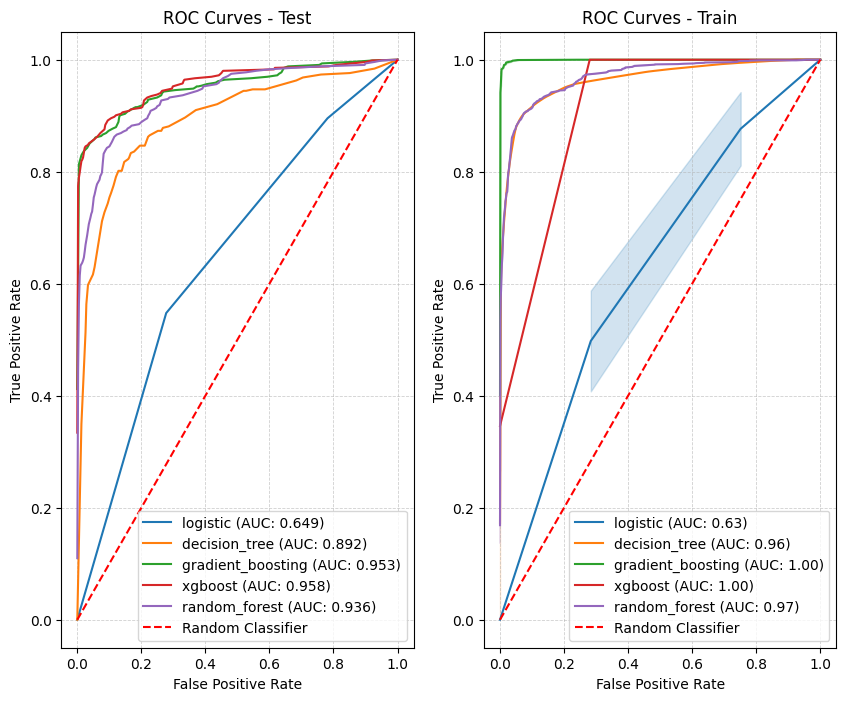

In [45]:
model_resampled.plot_roc_curves()

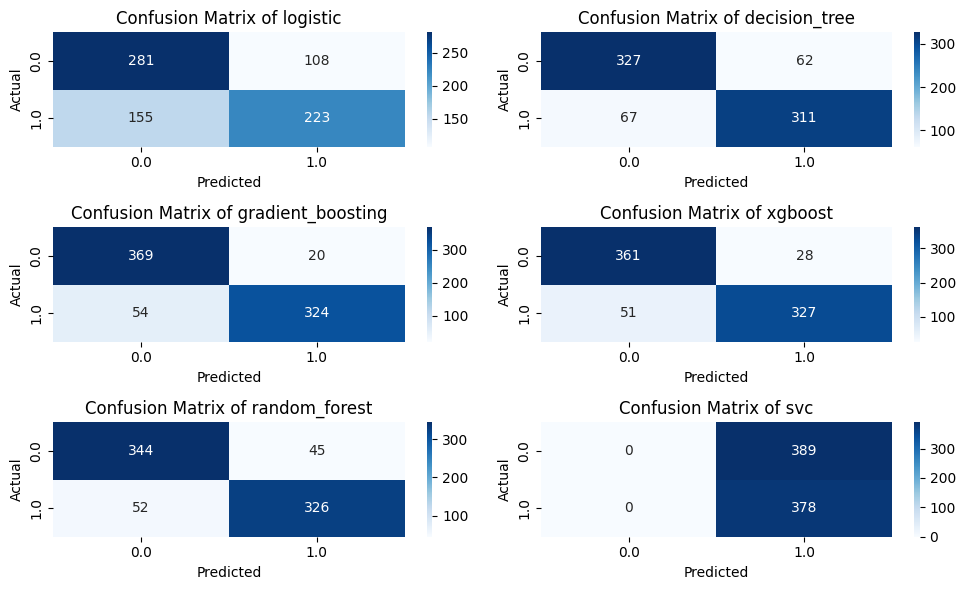

In [46]:
model_resampled.plot_confusion_matrix()

In [47]:
df_metrics_resampled = pd.DataFrame()
for k in model_resampled.resultados.keys():
    df_it = model_resampled.resultados[k]["metrics"]
    df_it["method"] = k
    df_metrics_resampled = pd.concat([df_metrics_resampled, df_it])

df_resultados_colores_resampled = df_metrics_resampled.copy()
df_resultados_colores_resampled.reset_index(inplace = True)
df_resultados_colores_resampled = df_resultados_colores_resampled.style.apply(color_filas_por_modelo, axis=1)
df_resultados_colores_resampled

,index,precision,accuracy,recall,f1_score,kappa,auc,time,n_jobs,method
0,train,0.656676,0.625489,0.535556,0.589963,0.251804,0.626507,0.003052,None,logistic
1,test,0.673716,0.657106,0.589947,0.629055,0.312862,0.649110,0.003052,None,logistic
2,train,0.936989,0.915595,0.892222,0.914058,0.831234,0.963763,0.001995,12,decision_tree
3,test,0.833780,0.831812,0.822751,0.828229,0.663492,0.892082,0.001995,12,decision_tree
4,train,0.996599,0.986585,0.976667,0.986532,0.973172,0.999543,0.007998,12,gradient_boosting
5,test,0.941860,0.903520,0.857143,0.897507,0.806755,0.953279,0.007998,12,gradient_boosting
6,train,1.000000,0.999441,0.998889,0.999444,0.998882,1.000000,0.022356,None,xgboost
7,test,0.921127,0.897001,0.865079,0.892224,0.793783,0.958257,0.022356,None,xgboost
8,train,0.942080,0.915036,0.885556,0.912944,0.830129,0.968773,0.032922,-1,random_forest
9,test,0.878706,0.873533,0.862434,0.870494,0.746948,0.935882,0.032922,-1,random_forest


In [48]:
import pickle
with open('../models/model_resampled.pkl', 'wb') as file:
    pickle.dump(model_resampled.resultados["xgboost"]["mejor_modelo"], file)